In [13]:
#!/usr/bin/env python3
"""
single_neuron_logistic_model.py

Implementation of a single-neuron logistic regression model using pure NumPy,
loading dataset from a CSV file with feature scaling for stability and robust
argument parsing in interactive environments.
"""

import numpy as np
import argparse
import sys
from typing import Optional, Tuple

class LogisticNeuron:
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr: float = learning_rate
        self.w: Optional[np.ndarray] = None
        self.b: float = 0.0

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Compute the sigmoid activation"""
        return 1 / (1 + np.exp(-z))

    def initialize(self, n_features: int) -> None:
        """Initialize weights and bias to zeros"""
        self.w = np.zeros((n_features, 1), dtype=float)
        self.b = 0.0

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Forward pass: compute predictions"""
        assert self.w is not None, \
            "Model weights not initialized. Call train() with data or initialize() first."
        return self.sigmoid(np.dot(X, self.w) + self.b)

    def compute_loss(self, A: np.ndarray, Y: np.ndarray) -> float:
        """Compute binary cross-entropy loss"""
        m = Y.shape[0]
        epsilon = 1e-8
        loss = - (1/m) * np.sum(
            Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon)
        )
        return float(loss)

    def backward(self, X: np.ndarray, A: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, float]:
        """Backward pass: compute gradients"""
        m = X.shape[0]
        dZ = A - Y
        dw = (1/m) * np.dot(X.T, dZ)
        db = float((1/m) * np.sum(dZ))
        return dw, db

    def train(
        self,
        X: np.ndarray,
        Y: np.ndarray,
        num_iters: int = 1000,
        print_loss: bool = False
    ) -> "LogisticNeuron":
        """Train the model using gradient descent"""
        self.initialize(X.shape[1])
        for i in range(num_iters):
            A = self.forward(X)
            loss = self.compute_loss(A, Y)
            dw, db = self.backward(X, A, Y)
            self.w -= self.lr * dw  # type: ignore
            self.b -= self.lr * db
            if print_loss and i % 100 == 0:
                print(f"Iteration {i}: loss = {loss:.4f}")
        return self

    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """Predict binary labels for inputs"""
        A = self.forward(X)
        return (A > threshold).astype(int)


def scale_features(
    X_train: np.ndarray, X_test: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """Standardize features: (X - mean) / std"""
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std_replaced = np.where(std == 0, 1, std)
    return (X_train - mean) / std_replaced, (X_test - mean) / std_replaced


def main() -> None:
    parser = argparse.ArgumentParser(
        description='Train a logistic neuron on a CSV dataset with feature scaling.'
    )
    parser.add_argument(
        '--data', '-d', type=str, default='fruit.csv',
        help='Path to CSV file with header: length_cm,weight_g,yellow_score,label'
    )
    parser.add_argument(
        '--lr', type=float, default=0.1,
        help='Learning rate'
    )
    parser.add_argument(
        '--iters', type=int, default=1000,
        help='Number of training iterations'
    )
    # Use parse_known_args to ignore extra args (e.g., from IPython)
    args, _ = parser.parse_known_args()

    # Load data from CSV
    try:
        data = np.genfromtxt(args.data, delimiter=',', skip_header=1)
    except Exception as e:
        print(f"Error loading data: {e}", file=sys.stderr)
        sys.exit(1)

    # Features and labels
    X = data[:, :3]
    Y = data[:, 3].reshape(-1, 1)

    # Shuffle and split (80/20)
    rng = np.random.RandomState(42)
    perm = rng.permutation(X.shape[0])
    X, Y = X[perm], Y[perm]
    split = int(0.8 * X.shape[0])
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]

    # Scale
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    # Train
    model = LogisticNeuron(learning_rate=args.lr)
    model.train(X_train_scaled, Y_train, num_iters=args.iters, print_loss=True)

    # Evaluate
    preds = model.predict(X_test_scaled)
    accuracy = float(np.mean(preds == Y_test))
    print(f"Test accuracy: {accuracy * 100:.2f}%")

if __name__ == "__main__":
    main()


Iteration 0: loss = 0.6931
Iteration 100: loss = 0.0839
Iteration 200: loss = 0.0497
Iteration 300: loss = 0.0358
Iteration 400: loss = 0.0281
Iteration 500: loss = 0.0232
Iteration 600: loss = 0.0197
Iteration 700: loss = 0.0172
Iteration 800: loss = 0.0153
Iteration 900: loss = 0.0138
Test accuracy: 100.00%


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Load the fruit dataset directly with numpy
data = np.genfromtxt('fruit.csv', delimiter=',', skip_header=1)
print("Dataset shape:", data.shape)
print("\nFirst few rows:")
print(data[:5])

# Prepare features and labels
X = data[:, :3]  # length_cm, weight_g, yellow_score
y = data[:, 3:4]  # label (keep as column vector)

# Split data (80% train, 20% test)
np.random.seed(42)
indices = np.random.permutation(len(X))
split_idx = int(0.8 * len(X))
train_idx, test_idx = indices[:split_idx], indices[split_idx:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Feature scaling
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train_scaled = (X_train - X_train_mean) / X_train_std
X_test_scaled = (X_test - X_train_mean) / X_train_std

print(f"\nTrain set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")
print(f"Labels shape - Train: {y_train.shape}, Test: {y_test.shape}")


Dataset shape: (16, 4)

First few rows:
[[1.52e+01 1.80e+02 9.00e-01 1.00e+00]
 [1.28e+01 1.50e+02 8.50e-01 1.00e+00]
 [1.85e+01 2.00e+02 9.50e-01 1.00e+00]
 [8.50e+00 1.20e+02 1.50e-01 0.00e+00]
 [7.20e+00 1.40e+02 1.00e-01 0.00e+00]]

Train set: (12, 3), Test set: (4, 3)
Labels shape - Train: (12, 1), Test: (4, 1)


In [15]:
class LogisticNeuron:
    def __init__(self, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.weights = None
        self.bias = 0.0
        self.losses = []
        self.accuracies = []
    
    def sigmoid(self, z):
        # Clip z to prevent overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y, epochs=500):
        # Initialize weights and bias
        n_features = X.shape[1]
        self.weights = np.random.normal(0, 0.01, (n_features, 1))
        self.bias = 0.0
        
        m = X.shape[0]  # number of samples
        
        for epoch in range(epochs):
            # Forward pass
            z = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(z)
            
            # Compute loss (binary cross-entropy)
            epsilon = 1e-15  # prevent log(0)
            predictions = np.clip(predictions, epsilon, 1 - epsilon)
            loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
            
            # Compute accuracy
            binary_predictions = (predictions >= 0.5).astype(int)
            accuracy = np.mean(binary_predictions == y)
            
            # Store metrics
            self.losses.append(loss)
            self.accuracies.append(accuracy)
            
            # Backward pass (gradients)
            dz = predictions - y
            dw = (1/m) * np.dot(X.T, dz)
            db = (1/m) * np.sum(dz)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Print progress
            if epoch % 100 == 0 or loss < 0.05:
                print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
                if loss < 0.05:
                    print(f"Early stopping at epoch {epoch} (loss < 0.05)")
                    break
    
    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        predictions = self.sigmoid(z)
        return (predictions >= 0.5).astype(int)



=== Training with Learning Rate = 0.01 ===
Epoch 0: Loss = 0.6933, Accuracy = 0.1667
Epoch 100: Loss = 0.3604, Accuracy = 1.0000
Epoch 200: Loss = 0.2467, Accuracy = 1.0000
Epoch 300: Loss = 0.1917, Accuracy = 1.0000
Epoch 400: Loss = 0.1589, Accuracy = 1.0000
Final Test Accuracy: 1.0000

=== Training with Learning Rate = 0.1 ===
Epoch 0: Loss = 0.6977, Accuracy = 0.0833
Epoch 100: Loss = 0.0838, Accuracy = 1.0000
Epoch 199: Loss = 0.0499, Accuracy = 1.0000
Early stopping at epoch 199 (loss < 0.05)
Final Test Accuracy: 1.0000

=== Training with Learning Rate = 0.5 ===
Epoch 0: Loss = 0.6946, Accuracy = 0.1667
Epoch 39: Loss = 0.0497, Accuracy = 1.0000
Early stopping at epoch 39 (loss < 0.05)
Final Test Accuracy: 1.0000


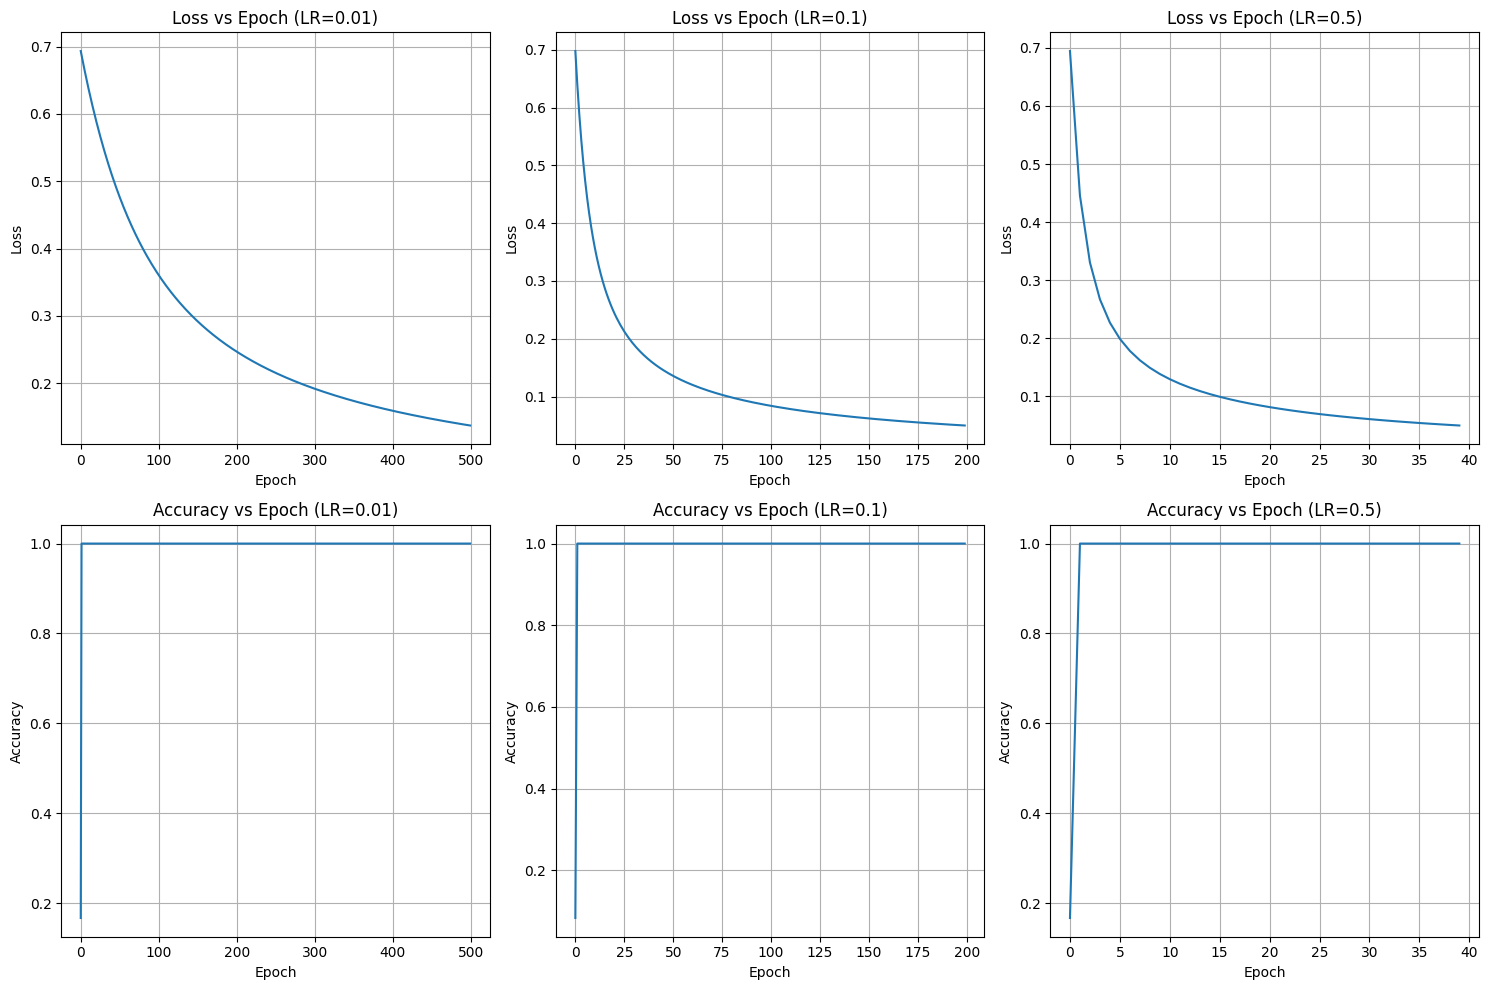


=== Summary ===
All models trained successfully with batch gradient descent!
Plots show loss and accuracy progression per epoch for different learning rates.


In [16]:
# Train the model with different learning rates
learning_rates = [0.01, 0.1, 0.5]

plt.figure(figsize=(15, 10))

for i, lr in enumerate(learning_rates):
    print(f"\n=== Training with Learning Rate = {lr} ===")
    
    # Create and train model
    model = LogisticNeuron(learning_rate=lr)
    model.fit(X_train_scaled, y_train, epochs=500)
    
    # Test the model
    test_predictions = model.predict(X_test_scaled)
    test_accuracy = np.mean(test_predictions == y_test)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    
    # Plot loss
    plt.subplot(2, 3, i+1)
    plt.plot(model.losses)
    plt.title(f'Loss vs Epoch (LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(2, 3, i+4)
    plt.plot(model.accuracies)
    plt.title(f'Accuracy vs Epoch (LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

plt.tight_layout()
plt.show()

print("\n=== Summary ===")
print("All models trained successfully with batch gradient descent!")
print("Plots show loss and accuracy progression per epoch for different learning rates.")
